In [14]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [15]:
import numpy as np
import pandas as pd
from skimage import measure
from scipy import ndimage
from scipy import signal


def mean_filter(img, size):
    weights = np.full(shape=(size, size), fill_value=1 / size ** 2)
    
    #return ndimage.filters.convolve(img, weights=weights)
    
    out = signal.fftconvolve(img, weights, mode='valid')
    return np.pad(out, (size - 1) // 2, mode='edge')


def find_interesting_pixels(img):
    
    # Determine which pixels have a high intensity with respect to their surrounding region
    means = mean_filter(img, 31)
    stds = mean_filter((img - means) ** 2, 31) ** .5
    mask = img > means + 3 * stds
    
    # Retrieve the connected components
    labels = measure.label(mask)
    
    # Filter the regions based on their properties
    interesting = []
    i = 0
    for region in measure.regionprops(labels):
        if region.area == 1 or region.area > 10 or region.eccentricity > .98:
            continue
        for x, y in region.coords:
            interesting.append({'x': x, 'y': y, 'region': i})
        i += 1
            
    return pd.DataFrame(interesting)

Example.

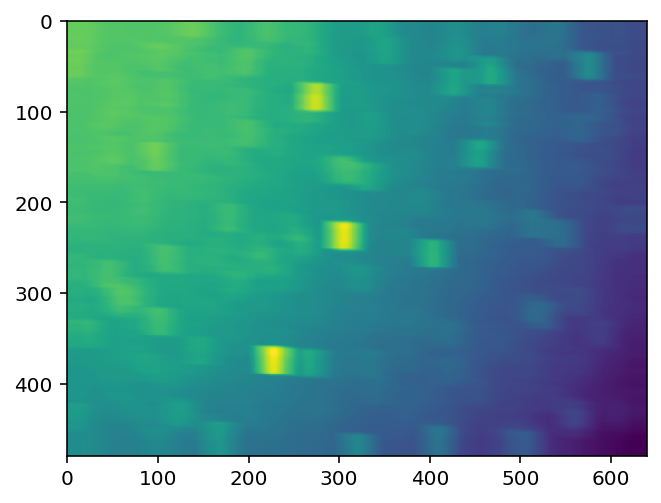

In [16]:
import imageio
import matplotlib.pyplot as plt

img = imageio.imread('data/spotGEO/train/10/1.png')
means = mean_filter(img, 31)
plt.imshow(means)

In [17]:
interesting = find_interesting_pixels(img)
interesting.head()

/Users/mhalford/opt/anaconda3/lib/python3.7/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/Users/mhalford/opt/anaconda3/lib/python3.7/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


,x,y,region
0,22,478,0
1,22,479,0
2,22,480,0
3,22,481,0
4,22,482,0


Do it for each image.

In [18]:
import pathlib
import tqdm

interesting = []

for part in ['train', 'test']:
    
    for seq in tqdm.tqdm(list(pathlib.Path(f'data/spotGEO/{part}').glob('*')), position=0):
        for frame in seq.glob('*.png'):

            interesting.append(find_interesting_pixels(imageio.imread(frame).T).assign(
                part=part,
                sequence=int(seq.name),
                frame=int(frame.stem)
            ))
            
interesting = pd.concat(interesting)

  0%|          | 0/1280 [00:00<?, ?it/s]/Users/mhalford/opt/anaconda3/lib/python3.7/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/Users/mhalford/opt/anaconda3/lib/python3.7/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
100%|██████████| 5120/5120 [38:5

In [19]:
interesting.to_pickle('data/interesting.pkl')

In [20]:
interesting.shape

(6549278, 6)

In [21]:
(5120 + 1280) * 480 * 640

1966080000

In [23]:
interesting.shape[0] / ((5120 + 1280) * 480 * 640)

0.0033311350504557293

In [ ]:
0.009799004109700521